In [1]:
"""CS231n: Image Classification 
"""

import numpy as np
import matplotlib.pyplot as plt
import pickle, os, random
from collections import Counter
from ipywidgets import interact, IntSlider, Dropdown
from sklearn.datasets import make_moons, make_circles, make_blobs


In [2]:
# CIFAR-10 Loading Utilities

def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        Y = datadict[b'labels']
        X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(folder_path):
    xs, ys = [], []
    for b in range(1, 6):
        f = os.path.join(folder_path, f'data_batch_{b}')
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    Xte, Yte = load_CIFAR_batch(os.path.join(folder_path, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


In [3]:
# Visualization Helpers

def visualize_samples(X, y, classes, samples_per_class=7):
    plt.figure(figsize=(14, 7))
    for cls_idx, cls in enumerate(classes):
        idxs = np.flatnonzero(y == cls_idx)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * len(classes) + cls_idx + 1
            plt.subplot(samples_per_class, len(classes), plt_idx)
            plt.imshow(X[idx].astype('uint8').transpose(1, 2, 0))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()


Train: (50000, 3, 32, 32) Test: (10000, 3, 32, 32)


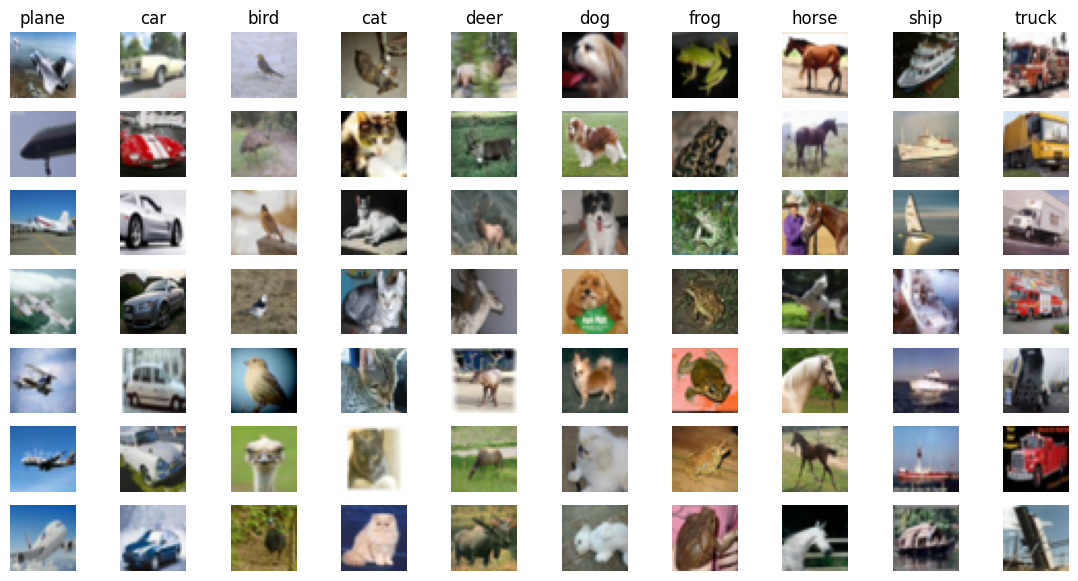

In [4]:

cifar_dir = '../cifar-10-batches-py'
if os.path.exists(cifar_dir):
    Xtr, Ytr, Xte, Yte = load_CIFAR10(cifar_dir)
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    print('Train:', Xtr.shape, 'Test:', Xte.shape)
    visualize_samples(Xtr, Ytr, classes)
else:
    print('CIFAR-10 directory not found. Skipping image visualization.')


In [9]:
# k-Nearest Neighbor Classifier

def l2_distance(a, b, axis = 1):
    return np.sqrt(np.sum((a - b) ** 2, axis=axis))

def l1_distance(a, b, axis = 1):
    return np.sum(np.abs(a - b), axis=axis)

class NearestNeighbor(object):
  def __init__(self):
    pass

  def train(self, X, y):
    """ X is N x D where each row is an example. Y is 1-dimension of size N """
    # the nearest neighbor classifier simply remembers all the training data
    self.Xtr = X
    self.ytr = y

  def predict(self, X):
    """ X is N x D where each row is an example we wish to predict label for """
    num_test = X.shape[0]
    # lets make sure that the output type matches the input type
    Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
    for i in range(num_test):
      # find the nearest training image to the i'th test image
      # using the L1 distance (sum of absolute value differences)
      distances = l1_distance(self.Xtr, X[i,:])
      # distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1)) # L2 distance
      min_index = np.argmin(distances) # get the index with smallest distance
      Ypred[i] = self.ytr[min_index] # predict the label of the nearest example

    return Ypred



from scipy import stats
class KNearestNeighbor:
    def __init__(self, k=5, dist='l2'):
        self.k = k
        self.dist = dist

    def train(self, X, y):
        self.Xtr = X
        self.ytr = y

    def predict(self, X):
        if self.dist == 'l1': # use L1 distance
            distances = l1_distance(X[:, None, :], self.Xtr[None, :, :], axis=2)
        else:
            distances = l2_distance(X[:, None, :], self.Xtr[None, :, :], axis=2)
        idx = np.argsort(distances, axis=1)[:, :self.k] # Indices of k nearest neighbors
        nearest_labels = self.ytr[idx] # Labels of k nearest neighbors
        preds = np.array([stats.mode(row, keepdims=True).mode[0] for row in nearest_labels])
        return preds


In [10]:
# Computing the accuracy of KNN on CIFAR-10 dataset
X_train, y_train, X_test, y_test = load_CIFAR10(cifar_dir)
Xtr_rows = X_train.reshape(X_train.shape[0], -1)
Xte_rows = X_test.reshape(X_test.shape[0], -1)

def compute_knn(num_train=100, num_test=20, k=3, dist='l2'):
    Xtr_sub = Xtr_rows[:num_train]
    ytr_sub = y_train[:num_train]
    Xte_sub = Xte_rows[:num_test]
    yte_sub = y_test[:num_test]

    knn = KNearestNeighbor(k=k, dist=dist)
    knn.train(Xtr_sub, ytr_sub)
    y_pred = knn.predict(Xte_sub)
    acc = np.mean(y_pred == yte_sub)
    print(f"Distance={dist}, k={k}, Train={num_train}, Test={num_test}, Accuracy={acc:.3f}")

# interactive sliders to change parameters
interact(
    compute_knn,
    num_train=IntSlider(min=200, max=5000, step=200, value=1000),
    num_test=IntSlider(min=100, max=1000, step=100, value=200),
    k=IntSlider(min=1, max=20, step=1, value=5),
    dist=Dropdown(options=['l1', 'l2'], value='l2', description='Distance')
);


interactive(children=(IntSlider(value=1000, description='num_train', max=5000, min=200, step=200), IntSlider(v…

In [11]:
# 2D Decision Boundary Visualization

def make_2d_data(n_samples=200, noise=0.8):
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=0)
    return X, y

def plot_knn_decision_boundary(samples=200, noise=0.8, k=3, dist='l2'):
    X, y = make_2d_data(n_samples=samples, noise=noise/10)
    knn = KNearestNeighbor(k=k, dist=dist)
    knn.train(X, y)

    # Create a meshgrid
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict over grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = knn.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(7, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(f'2D dataset — k={k}, distance={dist}')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

# Interactive plot
interact(
    plot_knn_decision_boundary,
    samples=IntSlider(min=100, max=1000, step=100, value=200),
    noise=IntSlider(min=0, max=50, step=1, value=8),
    k=IntSlider(min=1, max=15, step=1, value=3),
    dist=Dropdown(options=['l1', 'l2'], value='l2', description='Distance'),
);


interactive(children=(IntSlider(value=200, description='samples', max=1000, min=100, step=100), IntSlider(valu…

In [12]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

# Create folds from the first 1500 rows of flattened training data
X_train_folds = np.array_split(Xtr_rows[:1500], num_folds)
y_train_folds = np.array_split(y_train[:1500], num_folds)

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

for k in k_choices:
    k_to_accuracies[k] = []

    for i in range(num_folds):
        # Create num_folds-1 of the data and labels as the training samples
        X_train_temp = np.concatenate(np.compress(np.arange(num_folds) != i, X_train_folds, axis=0))
        y_train_temp = np.concatenate(np.compress(np.arange(num_folds) != i, y_train_folds, axis=0))

        # Train the classifier based on the training data
        knn = KNearestNeighbor(k=k, dist='l2')
        knn.train(X_train_temp, y_train_temp)

        # Predict using the remaining fold representing validation data
        y_pred_temp = knn.predict(X_train_folds[i])

        # Compute the accuracy of the predicted label
        num_correct = np.sum(y_pred_temp == y_train_folds[i])
        k_to_accuracies[k].append(num_correct / len(y_pred_temp))

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    print(f'k = {k}, accuracies: {k_to_accuracies[k]}')

k = 1, accuracies: [np.float64(0.22333333333333333), np.float64(0.25666666666666665), np.float64(0.25), np.float64(0.22333333333333333), np.float64(0.23333333333333334)]
k = 3, accuracies: [np.float64(0.17666666666666667), np.float64(0.25333333333333335), np.float64(0.20666666666666667), np.float64(0.21666666666666667), np.float64(0.24333333333333335)]
k = 5, accuracies: [np.float64(0.21), np.float64(0.26), np.float64(0.22666666666666666), np.float64(0.23666666666666666), np.float64(0.2633333333333333)]
k = 8, accuracies: [np.float64(0.19333333333333333), np.float64(0.24333333333333335), np.float64(0.2633333333333333), np.float64(0.23333333333333334), np.float64(0.29)]
k = 10, accuracies: [np.float64(0.17666666666666667), np.float64(0.25333333333333335), np.float64(0.25333333333333335), np.float64(0.25), np.float64(0.32)]
k = 12, accuracies: [np.float64(0.18666666666666668), np.float64(0.2633333333333333), np.float64(0.24666666666666667), np.float64(0.24333333333333335), np.float64(0.3

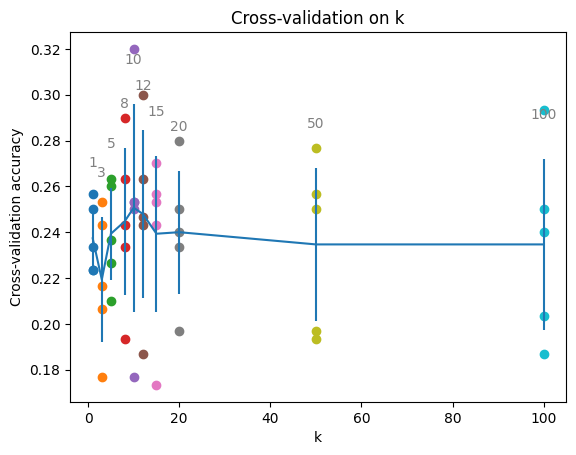

In [13]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
# show k numbers for each index on the plot in the same colors that they are plotted
for i, k in enumerate(sorted(k_to_accuracies.keys())):
    plt.text(k, accuracies_mean[i] + accuracies_std[i] + 0.0175, str(k), 
             horizontalalignment='center', color='grey')
plt.show()

First 10 pixel values of the original image:
[[ 59  62  63]
 [ 43  46  45]
 [ 50  48  43]
 [ 68  54  42]
 [ 98  73  52]
 [119  91  63]
 [139 107  75]
 [145 110  80]
 [149 117  89]
 [149 120  93]]
L2 distance between original and occluded image: 333.78
L2 distance between original and shifted image: 469.83
L2 distance between original and tinted image: 589.35


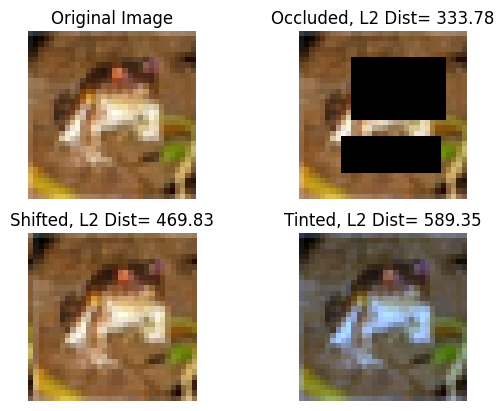

In [20]:
# store and display the first image in the training set
image = X_train[0].astype('uint8').transpose(1, 2, 0)

# print the first 10 pixel values of the original image
print("First 10 pixel values of the original image:")
print(image.reshape(-1, 3)[:10])

# create 3 different versions of the image: occluded, shifted, tinted. measure the l2 distance between all 3 images and the original

# display original
plt.subplot(221)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

# occluded image
occluded = image.copy() # create occluded image
occluded[5:17, 10:28, :] = 0
occluded[20:27, 8:27, :] = 0
# measure l2 distance from original image
occ_dist = l2_distance(image.flatten(), occluded.flatten(), axis=0)
print(f'L2 distance between original and occluded image: {occ_dist:.2f}')
# plot occluded image
plt.subplot(222)
plt.imshow(occluded)
plt.axis('off')
plt.title('Occluded, L2 Dist= {:.2f}'.format(occ_dist))

# shifted image
shifted = np.roll(image, shift=1, axis=1)
# measure l2 distance from original image
shift_dist = l2_distance(image.flatten(), shifted.flatten(), axis=0)
print(f'L2 distance between original and shifted image: {shift_dist:.2f}')
# plot shifted image
plt.subplot(223)
plt.imshow(shifted)
plt.axis('off')
plt.title('Shifted, L2 Dist= {:.2f}'.format(shift_dist))

# tinted image
tinted = image.copy()
tinted = (image * np.array([0.7, 0.9, 1.3])).clip(0, 255).astype(np.uint8)
# measure l2 distance from original image
tint_dist = l2_distance(image.flatten(), tinted.flatten(), axis=0)
print(f'L2 distance between original and tinted image: {tint_dist:.2f}')
# plot tinted image
plt.subplot(224)
plt.imshow(tinted)
plt.axis('off')
plt.title('Tinted, L2 Dist= {:.2f}'.format(tint_dist))

plt.show()
